In [10]:
import sys
from pathlib import Path

# add project root to sys.path
project_root = Path.cwd().parent   # if notebook is inside "notebooks/"
sys.path.append(str(project_root))

In [11]:
import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt
import os

# ensure cache exists
os.makedirs("data/cache", exist_ok=True)

fastf1.Cache.enable_cache("data/cache")

session = fastf1.get_session(2024, "Monaco", "R")
session.load(telemetry=True, laps=True, weather=True)

print(session.drivers)   # should now show driver list (HAM, VER, etc.)


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


/Users/yashbhalla/anaconda3/lib/python3.11/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/var/folders/xl/t65qg22d6q17x0fsg_5td6g00000gn/T/ipykernel_22465/3813203388.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_b["LapTimeSec"] = laps_b["LapTime"].dt.total_seconds()


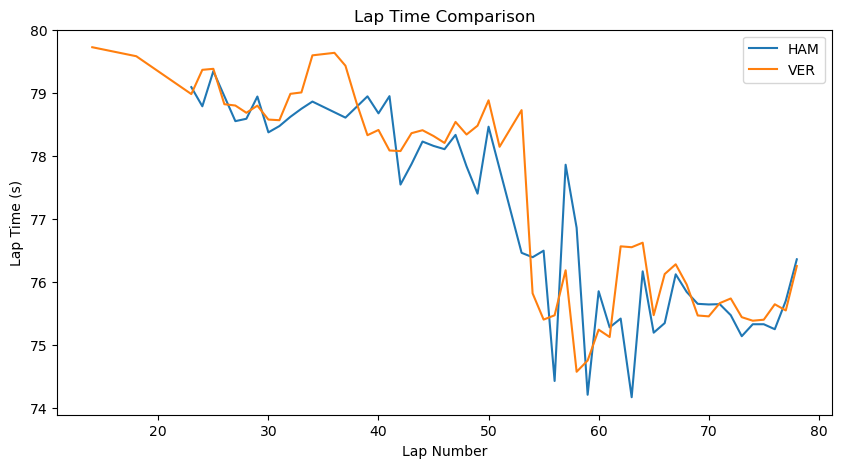

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# pick two drivers (you can replace codes with session.drivers list)
driver_a = "HAM"
driver_b = "VER"

laps_a = session.laps.pick_driver(driver_a).pick_quicklaps()
laps_b = session.laps.pick_driver(driver_b).pick_quicklaps()

# convert to seconds
laps_a["LapTimeSec"] = laps_a["LapTime"].dt.total_seconds()
laps_b["LapTimeSec"] = laps_b["LapTime"].dt.total_seconds()

# ---- Plot lap time traces ----
plt.figure(figsize=(10,5))
plt.plot(laps_a["LapNumber"], laps_a["LapTimeSec"], label=driver_a)
plt.plot(laps_b["LapNumber"], laps_b["LapTimeSec"], label=driver_b)
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.title("Lap Time Comparison")
plt.legend()
plt.show()

In [4]:
def stint_summary(laps):
    g = laps.groupby("Stint")
    return g.agg(
        compound=("Compound","first"),
        laps=("LapNumber","count"),
        avg_laptime_s=("LapTimeSec","mean")
    ).reset_index()

print(f"{driver_a} stints:\n", stint_summary(laps_a))
print(f"{driver_b} stints:\n", stint_summary(laps_b))

HAM stints:
    Stint compound  laps  avg_laptime_s
0    2.0   MEDIUM    24      78.476667
1    3.0     HARD    26      75.673192
VER stints:
    Stint compound  laps  avg_laptime_s
0    2.0   MEDIUM    30      78.776300
1    3.0     HARD    26      75.798231


In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def build_stint_dataset(session, driver):
    laps = session.laps.pick_driver(driver).pick_quicklaps().copy()
    laps["LapTimeSec"] = laps["LapTime"].dt.total_seconds()
    # Keep relevant fields
    return laps[["LapNumber","Stint","Compound","TyreLife","LapTimeSec"]]

ham_data = build_stint_dataset(session, "HAM")
ver_data = build_stint_dataset(session, "VER")

all_data = pd.concat([ham_data, ver_data])
all_data.head()

/Users/yashbhalla/anaconda3/lib/python3.11/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/yashbhalla/anaconda3/lib/python3.11/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


,LapNumber,Stint,Compound,TyreLife,LapTimeSec
490,23.0,2.0,MEDIUM,22.0,79.089
491,24.0,2.0,MEDIUM,23.0,78.785
492,25.0,2.0,MEDIUM,24.0,79.342
494,27.0,2.0,MEDIUM,26.0,78.549
495,28.0,2.0,MEDIUM,27.0,78.587


In [6]:
def fit_tyre_models(data):
    models = {}
    for comp in data["Compound"].unique():
        df = data[data["Compound"] == comp]
        X = sm.add_constant(df["TyreLife"])   # intercept + slope
        y = df["LapTimeSec"]
        model = sm.OLS(y, X).fit()
        base, k = model.params["const"], model.params["TyreLife"]
        models[comp] = {"base": base, "k": k, "r2": model.rsquared}
    return models

tyre_params = fit_tyre_models(all_data)
print(tyre_params)

{'MEDIUM': {'base': 79.93149967938503, 'k': -0.03655910808554527, 'r2': 0.4452299423074505}, 'HARD': {'base': 76.06205599046967, 'k': -0.021756296800543418, 'r2': 0.04329690204587966}}


In [13]:
from sim.sim_tyres import TyreModel
from sim.sim_strategy import simulate_plan

tyre_model = TyreModel({c: {"base": p["base"], "k": p["k"]}
                        for c,p in tyre_params.items()})

race_laps = session.total_laps

# Try strategies again
plan1 = [(25, "HARD")]
t1 = simulate_plan(race_laps, "SOFT", plan1, tyre_model)

plan2 = [(18, "MED"), (50, "HARD")]
t2 = simulate_plan(race_laps, "SOFT", plan2, tyre_model)

print(f"Real-data fit 1-stop: {t1:.1f} sec")
print(f"Real-data fit 2-stop: {t2:.1f} sec")

ModuleNotFoundError: No module named 'sim.sim_tyres'

KeyError: 'SOFT'

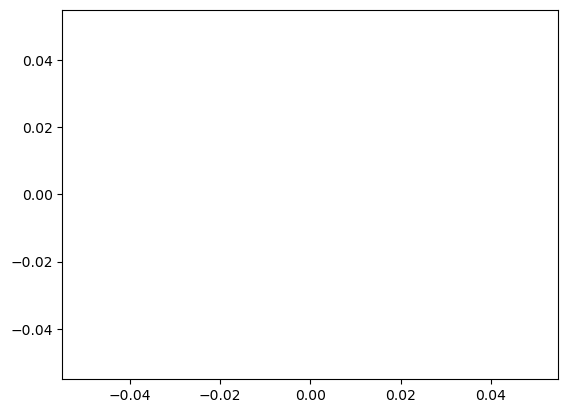

In [8]:
import matplotlib.pyplot as plt

for comp in ["SOFT","MED","HARD"]:
    df = all_data[all_data["Compound"]==comp]
    plt.scatter(df["TyreLife"], df["LapTimeSec"], alpha=0.6, label=f"{comp} laps")
    base, k = tyre_params[comp]["base"], tyre_params[comp]["k"]
    xs = np.arange(1, df["TyreLife"].max()+1)
    plt.plot(xs, base + k*xs, label=f"{comp} fit")
plt.xlabel("Tyre Life (laps)")
plt.ylabel("Lap Time (s)")
plt.legend()
plt.show()